In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
from lifelines import CoxPHFitter
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

In [2]:
df = pd.read_csv("./churn_dataset.csv")

In [3]:
def data_processing(df):
    df = df.copy()
    for col in ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]:
        df[col] = df[col].map({"No": 0, "Yes": 1})
    for col in ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]:
        df[col] = df[col].map({"No": 0, "No internet service": 0, "Yes": 1})
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.replace(" ", "0.0"))
    df['MultipleLines'] = df['MultipleLines'].map({"No": 0, "No phone service": 0, "Yes": 1})
    df = pd.get_dummies(df.drop(["customerID"], axis=1), drop_first=True)
    return df

In [4]:
train_df = data_processing(df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   Partner                                7043 non-null   int64  
 2   Dependents                             7043 non-null   int64  
 3   tenure                                 7043 non-null   int64  
 4   PhoneService                           7043 non-null   int64  
 5   MultipleLines                          7043 non-null   int64  
 6   OnlineSecurity                         7043 non-null   int64  
 7   OnlineBackup                           7043 non-null   int64  
 8   DeviceProtection                       7043 non-null   int64  
 9   TechSupport                            7043 non-null   int64  
 10  StreamingTV                            7043 non-null   int64  
 11  Stre

In [5]:
X = train_df.drop("Churn", axis=1)
y = train_df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"{X_train.shape=}, {y_train.shape=}, {X_test.shape=}, {y_test.shape=}")

X_train.shape=(5634, 23), y_train.shape=(5634,), X_test.shape=(1409, 23), y_test.shape=(1409,)


### Classification

In [6]:
lr = LogisticRegression(max_iter=50000)
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring="f1")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"Model f1 score on Train Dataset: {scores.mean()}")
print(f"Model f1 score on Test Dataset: {f1_score(y_test, y_pred)}")

Model f1 score on Train Dataset: 0.6014061730376815
Model f1 score on Test Dataset: 0.5821325648414986


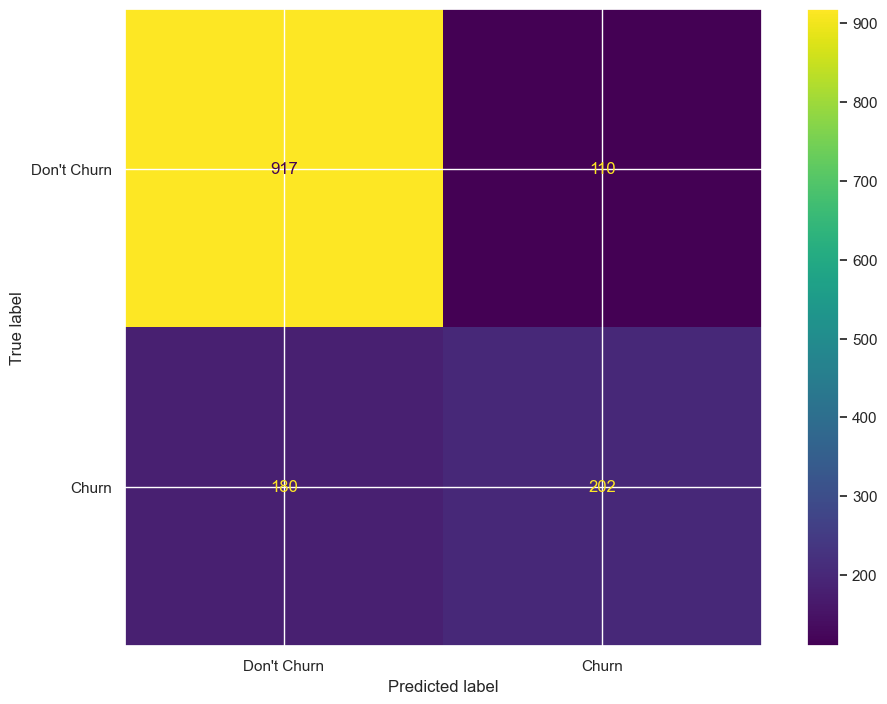

In [7]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm).from_predictions(y_test, y_pred, display_labels=["Don't Churn", "Churn"])
plt.show()

In [8]:
rf = RandomForestClassifier(n_estimators=500,max_depth=10, min_samples_split=2, n_jobs=-1)
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1")
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"Model f1 score on Train Dataset: {scores.mean()}")
print(f"Model f1 score on Test Dataset: {f1_score(y_test, y_pred)}")

Model f1 score on Train Dataset: 0.5850420546422062
Model f1 score on Test Dataset: 0.5565749235474006


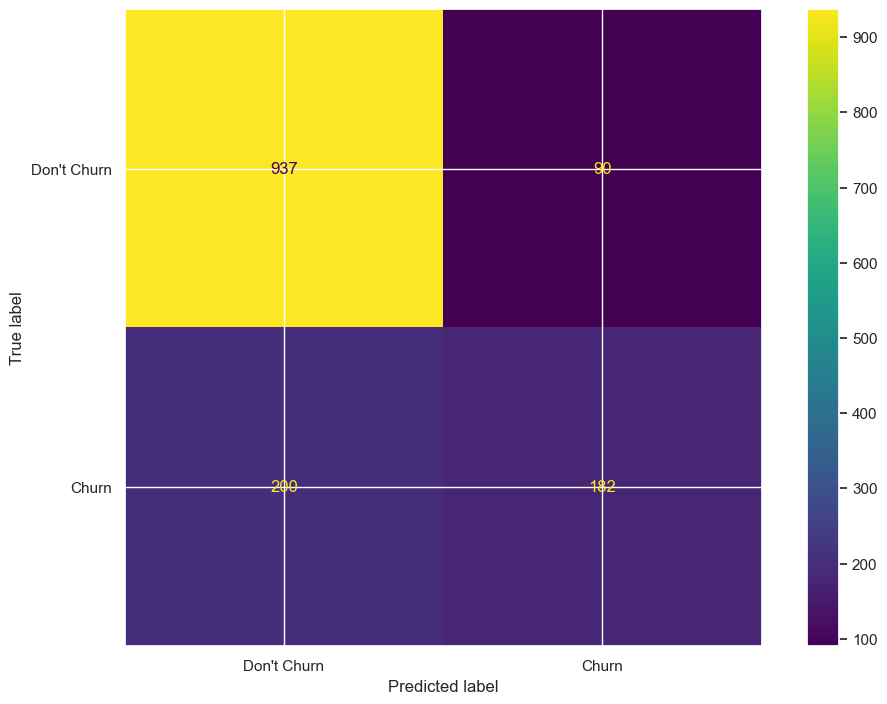

In [9]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm).from_predictions(y_test, y_pred, display_labels=["Don't Churn", "Churn"])
plt.show()

In [ ]:
svc = SVC(C=1.0, kernel='rbf', class_weight='balanced')
scores = cross_val_score(svc, X_train, y_train, cv=5, scoring="f1")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(f"Model f1 score on Train Dataset: {scores.mean()}")
print(f"Model f1 score on Test Dataset: {f1_score(y_test, y_pred)}")

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm).from_predictions(y_test, y_pred, display_labels=["Don't Churn", "Churn"])
plt.show()

### Survival Analysis

In [ ]:
cph = CoxPHFitter()
cph.fit(train_df, duration_col='tenure', event_col='Churn')

cph.print_summary()

To Be Continued